In [63]:
import os, shutil
from glob import glob
import random
import time
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

import matplotlib.pyplot as plt

from google.colab import files

# ЗАГРУЗКА ДАННЫХ

Будем использовать набор данных атрибутов CelebFaces (CelebA) от Kaggle и Google Colab https://www.kaggle.com/jessicali9530/celeba-dataset

## Присоединяем kaggle
Набор данных можно загрузить непосредственно в вашу среду Google Colab с помощью [Kaggle API] (https://www.kaggle.com/docs/api)

In [64]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

## Загружаем Kaggle.json, загруженный из вашей зарегистрированной учетной записи kaggle.

In [65]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"dansamara","key":"01987a35596ea9134f737f2282bfe026"}'}

## Верифицируем Kaggle. Сохраняем датасет в папку '/content'

In [66]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Распаковка

In [67]:
# Распаковываем в папку '/content/data'
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
  zipObj.extractall('./data/')

# НАСТРОЙКА ДАННЫХ

In [68]:
# Путь до папки изображений
IMAGES_SOURCE_FOLDER = '/content/data/img_align_celeba/img_align_celeba'  # Путь до исходных файлов
IMAGES_FOLDER = '/content/data/img_align_celeba/classes'  # Путь до файлоп, разложенных по классам
CSV_FILE = '/content/data/list_attr_celeba.csv'
IMG_HEIGHT = IMG_WIDTH = 128
IMG_CHANELS = 3
INPUT_DIM = (128, 128, 3) # Массив изображений
NUM_CLASSES = 2

## Количество изображений

Количество изображений:202599
Размер изобрадения: (218, 178, 3)


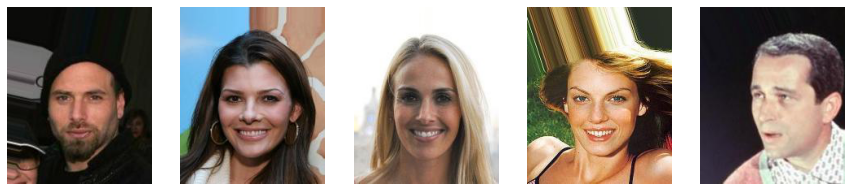

In [69]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном
file_names = np.array(glob(IMAGES_SOURCE_FOLDER + '/*.jpg'))
img_count = len(file_names)
print('Количество изображений:' + str(img_count))

fig = plt.figure(figsize=(15, 4))
for i in range(5):
  img = image.load_img(file_names[i])
  img_tensor = image.img_to_array(img)/255
  if (i == 0):
    print('Размер изобрадения:', img_tensor.shape)
  plt.subplot(1, 5, i+1)
  plt.imshow(img_tensor)
  plt.axis('off')
plt.show()

# ДАННЫЕ

## Датафрейм
Из всех колонок выбираем только 
* image_id
* Male

In [70]:
df = pd.read_csv(CSV_FILE)
print('Датафрем:', df.head(10), '\n')

df_y = df[['image_id', 'Male']]

df_label = df[['Male']].copy()
df_label.loc[df['Male'] < 0, 'Male'] = 0

Датафрем:      image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1
5  000006.jpg                -1  ...               -1      1
6  000007.jpg                 1  ...               -1      1
7  000008.jpg                 1  ...               -1      1
8  000009.jpg                -1  ...               -1      1
9  000010.jpg                -1  ...               -1      1

[10 rows x 41 columns] 



## Создаём датасет из 1000 (train) + 200 (test) изображений

In [89]:
train_list = []
test_list = []
for i, row in df_y.iterrows():
  if i >= 1200:
    break

  path_img = os.path.join(IMAGES_SOURCE_FOLDER, row['image_id'])
  pil_img = image.load_img(
      path = path_img, 
      color_mode='rgb', 
      target_size=(128, 128),
  )
  np_img = image.img_to_array(pil_img)

  if i < 1000:  # Train
    train_list.append(np_img)
  
  if i >= 1000:  # Test
    test_list.append(np_img)

label = df_label.to_numpy()
x_train = np.array(train_list)/255
y_train = label[0:1000]
x_test = np.array(test_list)/255
y_test = label[1000:1200]


class_names = ['Женщина', 'Мужчина']

print('Train:', x_train.shape, y_train.shape)
print('Test:', x_test.shape, y_test.shape)

Train: (1000, 128, 128, 3) (1000, 1)
Test: (200, 128, 128, 3) (200, 1)


# КЛАСС МОДЕЛИ
## Создание модели + генетический алгоритм

Количество свёрточных слоев - от 1 до 5

Бот будет иметь длину 50, по 10 ячеек на каждый свёрточный слой

0, 10, 20, 30, 40 - признак использования слоя (1 | 0), далее описание для первого слоя, остальные - аналогично
1. -- количество нейронов Conv2D слоя
2. -- функция активации Conv2D слоя
3. -- использование BatchNormalization
4. -- размер Dropout (0.1 - 0.5)
5. -- использование Dropout
6. и ниже - не используем = 0


In [94]:
class Genetic:
  def __init__(self):
    # --- НАСТРОЙКИ МОДЕЛИ ---
    self.input_shape = (128, 128, 3)  # Массив входного слоя
    self.max_layers = 5  # Максимальное количество свёрточных слоёв
    self.activation_list = ['linear', 'relu', 'elu', 'tanh', 'sigmoid']  # Функции активации
    # --- НАСТРОЙКИ ГЕНЕТИЧЕСКОГО АЛГОРИТМА ---
    self.popul = []  # Популяция ботов
    self.popul_n = 20  # Общее число ботов
    self.popul_surv = 10  # Количество выживших
    self.popul_new = self.popul_n - self.popul_surv  # Количество новых (столько новых ботов создается)
    self.bot_size = self.max_layers * 10  # Длина бота
    self.bot_mut = 0.01  # Коэффициент мутаций
    self.bot_val = []  # Одномерный массив значений этих ботов
    self.model_epochs = 20  # Количество эпох модели
    self.bot_epochs = 30  # Количество эпох эволюции ботов


  # --- СОЗДАНИЕ МОДЕЛИ ---
  def createModel(self, bot):
    data_input = Input(shape=self.input_shape, name='input')
    x = data_input
    for i in range(self.max_layers):  # Перебираем слои
      for j in range(10):
        n = i*10 + j
        if j == 0:  # Секция бота - неактивна - выходим из цикла по j
          if bot[n] == 0:
            break
        if j == 1:  # Количество нейронов
          neurons_num = 2 ** bot[n]
        if j == 2:  # Функция активации
          activation_func = self.activation_list[bot[n]]
          x = Conv2D(neurons_num, (3, 3), activation=activation_func, name=str(i+1)+'_Conv2D', padding='same')(x)
          x = MaxPooling2D(2, 2, name=str(i+1)+'_MaxPooling2D')(x)
        if j == 3:  # BatchNormalization
          if bot[n] == 1:
            x = BatchNormalization(name=str(i+1)+'_BatchNormalization')(x)
        if j == 4:  # Размер Dropout
          dropout_size = bot[n]
        if j == 5:  # Используем ли Dropout
          if bot[n] == 1:
            x = Dropout(dropout_size, name=str(i+1)+'_Dropout')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(10)(x)
    model = Model(inputs=data_input, outputs=x)
    # model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])  # Вместо to_categorical
    return model


  # --- СОЗДАНИЕ РАНДОМНОГО БОТА ДЛИНОЙ max_layers * 10 ---
  def createRandomBot(self):
    bot = []
    for i in range(self.max_layers):  # Перебираем слои
      for j in range(10):
        n = i*10 + j
        if j == 0:
          bot.append(random.randint(0, 1))  # Используем слой да | нет (1 | 0)
        if j == 1:
          bot.append(random.randint(3, 8))  # Число нейронов 2 ** bot[n]
        if j == 2:
          bot.append(random.randint(0, 4))  # Индекс функции активации
        if j == 3:
          bot.append(random.randint(0, 1))  # BatchNormalization - да | нет
        if j == 4:
          bot.append(random.randint(1, 5)/10)  # Размер Dropout = 0.1 - 0.5
        if j == 5:
          bot.append(random.randint(0, 1))  # Dropout - да | нет
        if j > 5:
          bot.append(0)  # Не используем значения = 0
    return bot


  # --- ЭВОЛЮЦИЯ ПОПУЛЯЦИИ БОТОВ ---
  def evolution(self):
    # Создаём случайных ботов
    for i in range(self.popul_n):
      new_bot = self.createRandomBot()
      self.popul.append(new_bot)
 
    print(f'--- Эволюция ботов, значения ошибок 5 лучших ботов ---')
    for epoch in range(self.bot_epochs):
      self.bot_val = []  # Обнуляем список значений ботов
      curr_time = time.time()
      # ВЫЧИСЛЯЕМ ТОЧНОСТЬ БОТОВ
      for i in range(self.popul_n):  # Пробегаем в цикле по всем ботам
        bot = self.popul[i]  # Берем очередного бота
        model, model_val = self.getLoss(bot)  # Вычисляем точность текущего бота
        self.bot_val.append(model_val)  # Добавляем полученное значение ошибки в список val

      sort_val = sorted(self.bot_val, reverse=0)  # Сортируем val по возрастанию
      print(f'{epoch}, {round(time.time()-curr_time, 2)} c, {sort_val[0:5]}')  # Выводим 5 лучших ботов

      # ДОБАВЛЯЕМ ВЫЖИВШИХ БОТОВ В НОВУЮ ПОПУЛЯЦИЮ
      new_popul = []  # Создаем пустой список под новую популяцию
      for i in range(self.popul_surv):  # Пробегаем по всем выжившим ботам
        index = self.bot_val.index(sort_val[i])  # Получаем индекс очередного бота из списка лучших в списке val
        new_popul.append(self.popul[index])  # Добавляем в новую популяцию бота из self.popul с индексом index

      # СОЗДАЁМ НОВЫХ БОТОВ И ДОБАВЛЯЕМ В ПОПУЛЯЦИЮ
      for i in range(self.popul_new):
        # Получаем родителей
        parent_index_1 = random.randint(0, self.popul_surv-1)  # Случайный индекс первого родителя в диапазоне от 0 до количества выживших
        parent_index_2 = random.randint(0, self.popul_surv-1)
        bot_parent_1 = new_popul[parent_index_1]  # Получаем первого бота-родителя по index_parent_1
        bot_parent_2 = new_popul[parent_index_2]

        # Создаём нового бота и рандомного (мутированного) бота, из которого мы рандомно будем брать ячеёки с вероятностью self.bot_mut
        new_bot = [] # Создаем пустой список под значения нового бота    
        bot_m = self.createRandomBot()  # Создаем полностью мутировавшего бота
        for j in range(self.bot_size):  # Пробегаем по всей длине размерности (22)      
          x = 0      
          rnd = random.random()  # Получаем случайное число в диапазоне от 0 до 1
          # Если rnd меньше 0.5, то берем значения от первого бота, иначе от второго
          if rnd < 0.5:
            x = bot_parent_1[j]
          else:
            x = bot_parent_2[j]
          
          # С вероятностью self.bot_mut устанавливаем значение бота из bot_m
          if (random.random() < self.bot_mut):
            x = bot_m[j]
            
          new_bot.append(x)  # Добавляем очередное значение в нового бота      
        new_popul.append(new_bot)  # Добавляем бота в новую популяцию      
      self.popul = new_popul  # Записываем в popul новую посчитанную популяцию
    
    return self.popul  # Возвращаем последнюю популяцию


  # --- ПОЛУЧЕНИЕ ОШИБКИ БОТА ---
  def getLoss(self, bot):
    val = 0
    model = self.createModel(bot)
    history = model.fit(x_train, y_train, epochs=self.model_epochs, validation_data=(x_test, y_test), verbose=0)   
    val = history.history["val_loss"][-1]  # Возвращаем точность на проверочной выборке с последней эпохи
    return model, val  # Возвращаем модель и точность


  # --- ОТОБРАЖЕНИЕ 25 ИЗОЮРАЖЕНИЙ ---
  def plotImages(self, x, y=y_train):
    plt.figure(figsize=(15, 15))
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[y[i][0]])
    plt.show()


# ПОСМОТРИМ 25 ИЗОБРАЖЕНИЙ

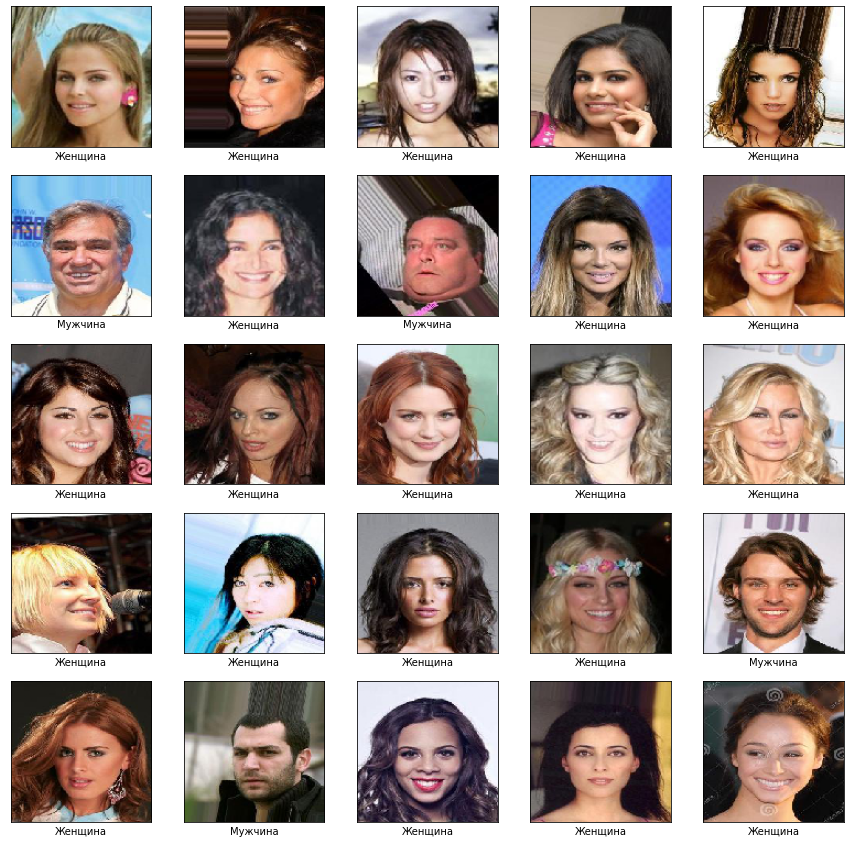

In [95]:
GEN = Genetic()
GEN.plotImages(x_test[0:25], y_test[0:25])

# СОЗДАДИМ СЛУЧАЙНЫЙ БОТ И МОДЕЛЬ
Для проверки работы класса

[0, 5, 1, 0, 0.2, 1, 0, 0, 0, 0, 1, 3, 2, 0, 0.4, 0, 0, 0, 0, 0, 0, 8, 1, 0, 0.4, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0.5, 1, 0, 0, 0, 0, 0, 5, 3, 1, 0.3, 0, 0, 0, 0, 0]


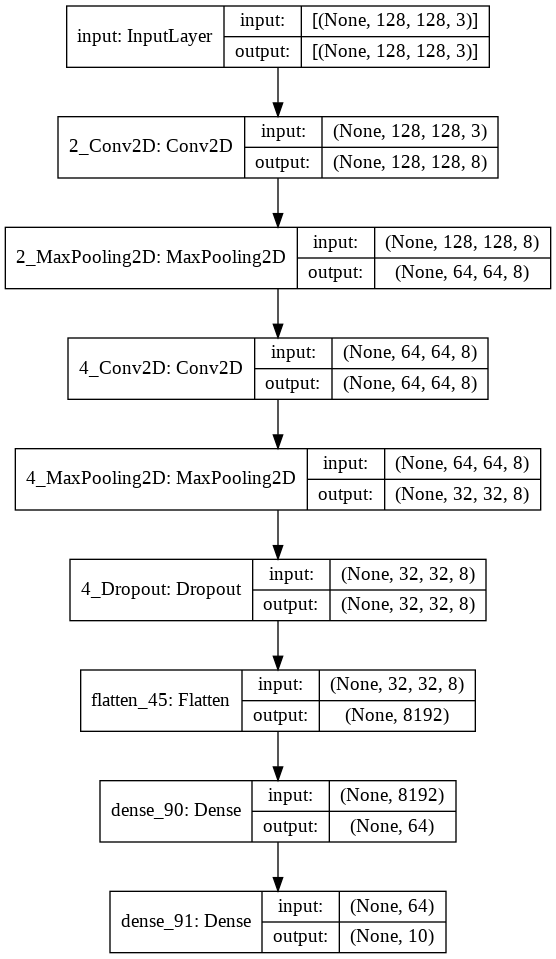

In [96]:
bot = GEN.createRandomBot()
print(bot)
model = GEN.createModel(bot)
plot_model(model, show_shapes=True, expand_nested=True)  # show_shapes=True - показать форму, 

# ЭВОЛЮЦИЯ БОТОВ

In [97]:
GEN = Genetic()
popul = GEN.evolution()
best_bot = popul[0]
print(best_bot)

--- Эволюция ботов, значения ошибок 5 лучших ботов ---
0, 395.0 c, [0.173723042011261, 0.20719677209854126, 0.2138068974018097, 0.24977479875087738, 0.29715701937675476]
1, 354.23 c, [0.20782430469989777, 0.231638565659523, 0.23958231508731842, 0.24048398435115814, 0.2774077355861664]
2, 366.51 c, [0.18567770719528198, 0.2610798180103302, 0.28518638014793396, 0.29473739862442017, 0.31083205342292786]
3, 361.31 c, [0.2325746864080429, 0.2609647214412689, 0.28243547677993774, 0.28350430727005005, 0.28640925884246826]
4, 465.14 c, [0.23611438274383545, 0.26269733905792236, 0.2816215455532074, 0.2980242669582367, 0.3070002794265747]
5, 368.3 c, [0.18821868300437927, 0.22586767375469208, 0.2514879107475281, 0.25436583161354065, 0.26960280537605286]
6, 425.62 c, [0.20358332991600037, 0.22000755369663239, 0.22611193358898163, 0.22664755582809448, 0.2316533625125885]
7, 429.98 c, [0.2048472911119461, 0.21446308493614197, 0.22494296729564667, 0.24821022152900696, 0.2621481418609619]
8, 377.54 c

## Лучшая модель


Model: "model_646"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
1_Conv2D (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
1_MaxPooling2D (MaxPooling2D (None, 64, 64, 256)       0         
_________________________________________________________________
1_BatchNormalization (BatchN (None, 64, 64, 256)       1024      
_________________________________________________________________
2_Conv2D (Conv2D)            (None, 64, 64, 16)        36880     
_________________________________________________________________
2_MaxPooling2D (MaxPooling2D (None, 32, 32, 16)        0         
_________________________________________________________________
2_BatchNormalization (BatchN (None, 32, 32, 16)        64

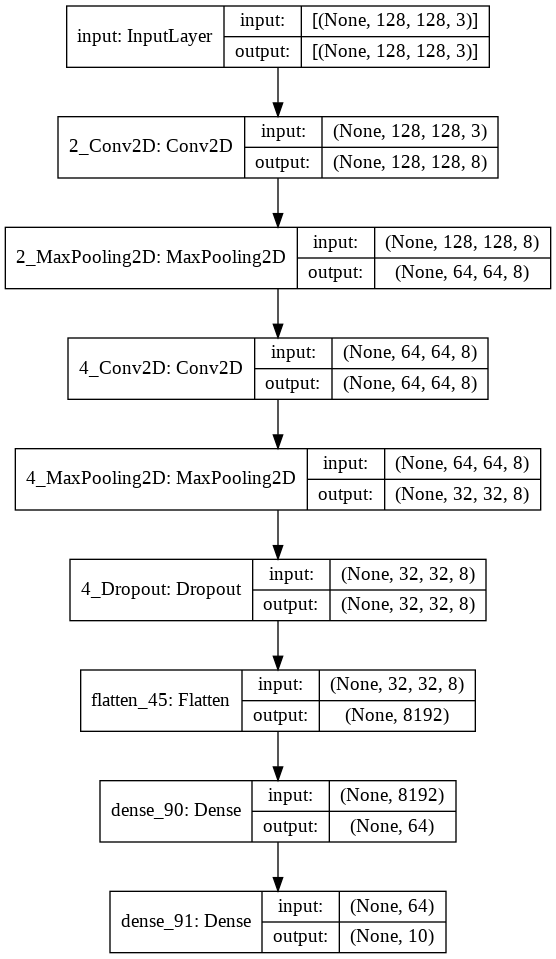

In [98]:
best_model = GEN.createModel(best_bot)
best_model.summary()
plot_model(model, show_shapes=True)

## Предсказанные значения

Epoch 1/20
32/32 [==============================] - 2s 62ms/step - loss: 1.0829 - accuracy: 0.5077 - val_loss: 0.6622 - val_accuracy: 0.6050
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.5326 - accuracy: 0.7534 - val_loss: 0.5762 - val_accuracy: 0.6700
Epoch 3/20
32/32 [==============================] - 2s 57ms/step - loss: 0.4219 - accuracy: 0.8138 - val_loss: 0.5510 - val_accuracy: 0.6900
Epoch 4/20
32/32 [==============================] - 2s 57ms/step - loss: 0.3880 - accuracy: 0.8207 - val_loss: 0.5675 - val_accuracy: 0.6450
Epoch 5/20
32/32 [==============================] - 2s 57ms/step - loss: 0.3158 - accuracy: 0.8740 - val_loss: 0.4616 - val_accuracy: 0.8150
Epoch 6/20
32/32 [==============================] - 2s 57ms/step - loss: 0.2665 - accuracy: 0.8831 - val_loss: 0.4291 - val_accuracy: 0.8200
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.1737 - accuracy: 0.9464 - val_loss: 0.3519 - val_accuracy: 0.8700
Epoch 8/20
32

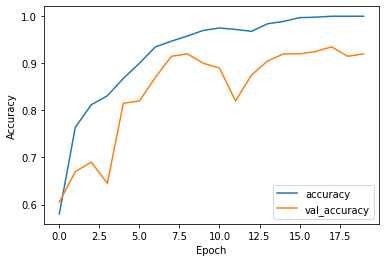

In [99]:
history = best_model.fit(x_train, y_train, epochs=GEN.model_epochs, validation_data=(x_test, y_test)) 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = best_model.evaluate(x_test,  y_test, verbose=2)  # Оценка модели на тестовых данных

## Выводим предсказанные значения

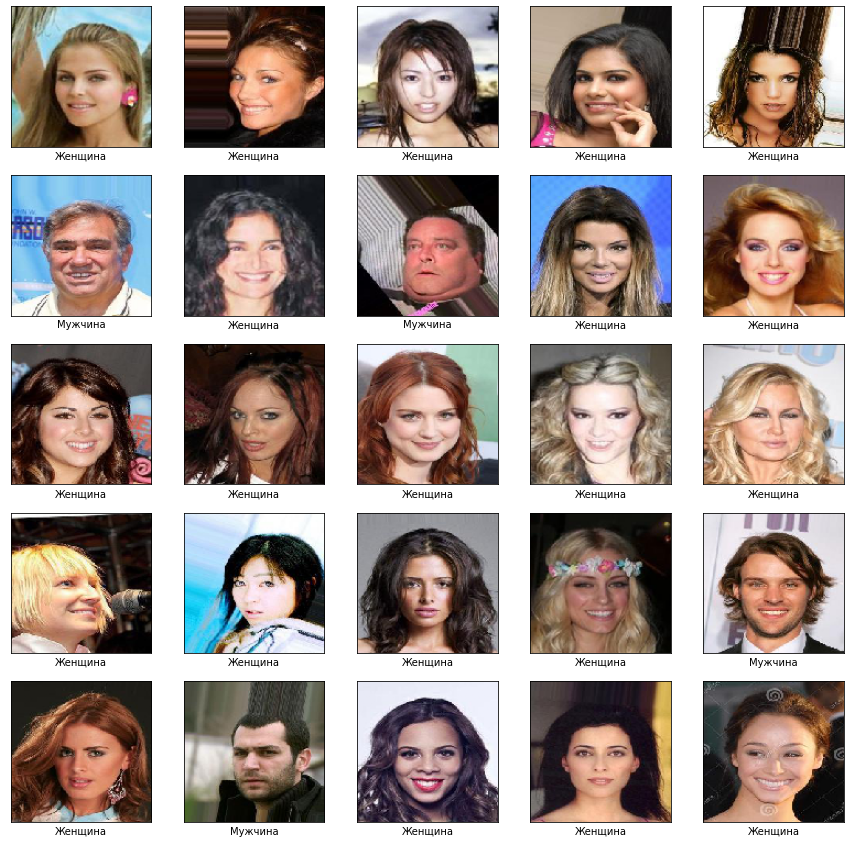

In [100]:
y_predict = best_model.predict(x_test[0:25])

y_index = []
for i in range(25):
  y = np.argmax(y_predict[i])
  y_index.append([y])

GEN.plotImages(x_test[0:25], y_index)

# ВЫВОД
Генетический алгоритм подобрал хороший вариант модели. При этом количество эпох обучения модели, количество эпох эволюции ботов и размер ботов был незначительный, но даже несмотря на это мы получили неплохой результат.